# Kalman filter for more than 1 state variable - N dimensional state vector Kalman filter

<u>**Predict**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
\bar \mu = \mu + \mu_{f_x} & \bar x = x + dx & \bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}\\
\bar\sigma^2 = \sigma_x^2 + \sigma_{f_x}^2 & \bar P = P + Q & \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q \\
\hline
\end{array}$

<u>**Update**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
& y = z - \bar x & \mathbf y = \mathbf z - \mathbf{H\bar x} \\
& K = \frac{\bar P}{\bar P+R}&
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1} \\
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2} & x = \bar x + Ky & \mathbf x = \bar{\mathbf x} + \mathbf{Ky} \\
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} & P = (1-K)\bar P &
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}} \\
\hline
\end{array}$

$\mathbf{Fx}$는 이전 time의 posterior state를 가지고 현재 state를 estimate하는 곱셈 결과이다. 즉, 그냥 시스템의 현재 상태를 보고 다음 상태를 예측한 값임

$\mathbf{Bu}$는 현재 time의 control input에 의해 state의 변화량이다. 즉, $\Delta\mathbf x$이다.

## MAKE DATA SIMULATION - Dog Tracker

In [1]:
import math
import numpy as np
from numpy.random import randn

def compute_dog_data(x, vel, z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)

## STEPS TO TAKE
#### 1. Design state variable: x
$$\mathbf x =\begin{bmatrix}x \\ \dot x\end{bmatrix}$$
#### 2. Design state covariance: P
$\mathbf P$ will be reduced at each time step -> So, start at large value 
$$
\mathbf P = \begin{bmatrix}500 & 0 \\ 0&49\end{bmatrix}
$$

#### 3. Design prior mean equation: process model  (Fx) + control model (Bu)
- process model
$$\mathbf{\bar x} = \mathbf{Fx}$$ 
    which we can make explicit as

                    

$$\begin{bmatrix} \bar x \\ \dot{\bar x}\end{bmatrix} = \begin{bmatrix}? & ? \\? & ?\end{bmatrix}\begin{bmatrix}x\\\dot x\end{bmatrix}$$

$$\begin{aligned}
\begin{bmatrix}\bar x \\ \bar{\dot x}\end{bmatrix} &= \begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix}  \begin{bmatrix}x \\ \dot x\end{bmatrix}\\
\end{aligned}$$


- control model

$$\Delta\mathbf x = \mathbf{Bu}$$

    If you can't control it with commands, matrix B is 0.
    
    
Therefore the complete Kalman filter equation for the prior mean is

$$\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$$

and this is the equation that is computed when you call `KalmanFilter.predict()`.

#### 4. Design process noise: Q
 - This is the difficult part; it depends on the system model
 
#### 5. Design measurement function: Hx

$$
\begin{aligned}
\textbf{y} &= \mathbf z - \mathbf{H\bar x}  \\
\begin{bmatrix}y \end{bmatrix} &= \begin{bmatrix}z\end{bmatrix} - \begin{bmatrix}?&?\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix} \\
\textbf{y} &= \mathbf z - \begin{bmatrix}1&0\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix} \\
&= [z] - [x]
\end{aligned}$$

And so, for our Kalman filter we set

$$\mathbf H=\begin{bmatrix}1&0\end{bmatrix}$$


#### 6. Design measurement noise: R

This is just the sensor uncertainty

$R = \begin{bmatrix}5\end{bmatrix}$


## IMPLEMENT THE KALMAN FILTER

In [2]:
np.random.seed(10)

process_var = 1 # variance in the dog's movement
sensor_var = 2 # variance in the sensor

x=0          # x1
velocity=1   # x2

dt = 1

F = np.array([[1., dt],[0.,1.]])
print(F.shape)
P = np.array([[500, 0.],[0, 49]])
print(P.shape)
H = np.array([[1., 0.]])
print(H.shape)
Q = np.array([[1., 2],[2, 4]])
print(Q.shape)
R = np.array([[5]])
print(R.shape)

B = 0
u = 0

# create list of measurements
gt, zs = compute_dog_data(x=x,vel=velocity,z_var=sensor_var, process_var=process_var, count=30, dt=dt)
# print(xs.shape)
# print(zs.shape)
# print(xs)
# print(zs)



(2, 2)
(2, 2)
(1, 2)
(2, 2)
(1, 1)


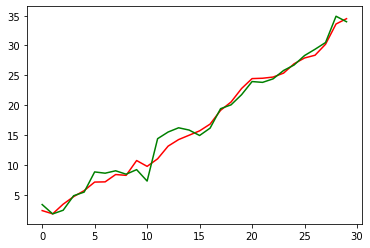

In [3]:
import matplotlib.pyplot as plt
plt.plot(gt, color='r') # ground truth
plt.plot(zs, color='g') # measurement

In [4]:

# y = zs[0] - H @ x
# print(y)
# print(H@P@H.T)
# # K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)
# K = P @ H.T /(H @ P @ H.T + R)
# print(K, K.shape)
# # x = x + np.dot(K, y)
# x = x + K*y
# print(x, x.shape)
# #P = (np.eye(len(P)) - K @ H) @ P
# #P = (np.eye(len(P))- K@H)@P@(np.eye(len(P))- K@H).T + K@R@K.T
# P = (np.eye(len(P))- K@H)@P@(np.eye(len(P))- K@H).T + R*K@K.T
# print(P, P.shape)


In [5]:
x = np.array([[0., 0.]]).T
print("initial state is {} and {}".format(x, x.shape))

def predict(x, F, B, u, P, Q):
    x = np.dot(F,x) + np.dot(B,u)
#     print('prior x is {}'.format(x))    
    P = F @ P @ F.T
#     print('prior P is {}'.format(P))
    return x, P

def update(z,x,H,P,R):
    y = z - H @ x
    K = P @ H.T / (H @ P @ H.T + R)
    x = x + K*y
#     print('post x is {}'.format(x))
    P = (np.eye(len(P))- K@H)@P@(np.eye(len(P))- K@H).T + R*K@K.T
#     print('post P is {}'.format(P))
#     print('\n')
    return x, P

xs, covs = [], []

for z in zs:
    # predict 
    x, P = predict(x, F, B, u, P, Q)  
    # update
    x, P = update(z,x,H,P,R)
    xs.append(x)
    covs.append(P)

print(type(x))
print(type(P))
xs, covs = np.array(xs), np.array(covs) 


initial state is [[0.]
 [0.]] and (2, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [6]:
print(xs.shape)
print(xs)

(30, 2, 1)
[[[ 3.31297095]
  [ 0.29569322]]

 [[ 1.9395689 ]
  [-1.19503912]]

 [[ 2.06899644]
  [-0.42209952]]

 [[ 3.83666284]
  [ 0.5052703 ]]

 [[ 4.98894638]
  [ 0.71950575]]

 [[ 7.32418025]
  [ 1.15823583]]

 [[ 8.53653895]
  [ 1.17068635]]

 [[ 9.4149111 ]
  [ 1.11236559]]

 [[ 9.7363536 ]
  [ 0.97306477]]

 [[10.18723833]
  [ 0.89075037]]

 [[ 9.87114673]
  [ 0.71858628]]

 [[11.70665426]
  [ 0.86409311]]

 [[13.3742885 ]
  [ 0.9604132 ]]

 [[14.81640942]
  [ 1.013884  ]]

 [[15.82997794]
  [ 1.01385139]]

 [[16.40516411]
  [ 0.97143438]]

 [[17.11307636]
  [ 0.94749575]]

 [[18.33685677]
  [ 0.97116085]]

 [[19.45403784]
  [ 0.98299265]]

 [[20.68204015]
  [ 1.00182811]]

 [[22.08696538]
  [ 1.03130617]]

 [[23.23765696]
  [ 1.03963089]]

 [[24.29854558]
  [ 1.04104735]]

 [[25.41338937]
  [ 1.04575547]]

 [[26.49936915]
  [ 1.04821705]]

 [[27.65940085]
  [ 1.05479148]]

 [[28.80613994]
  [ 1.05999386]]

 [[29.95181733]
  [ 1.06466562]]

 [[31.52557057]
  [ 1.09144929]]

 [[

In [7]:
print(covs.shape)
print(covs)

(30, 2, 2)
[[[4.95487365e+00 4.42238267e-01]
  [4.42238267e-01 4.46660650e+01]]

 [[4.54959350e+00 4.06341463e+00]
  [4.06341463e+00 8.00731707e+00]]

 [[4.02662151e+00 2.34987813e+00]
  [2.34987813e+00 2.33436738e+00]]

 [[3.44340971e+00 1.45829022e+00]
  [1.45829022e+00 9.68169500e-01]]

 [[2.97212230e+00 9.84112710e-01]
  [9.84112710e-01 4.90587530e-01]]

 [[2.60328299e+00 7.06887831e-01]
  [7.06887831e-01 2.82097999e-01]]

 [[2.31158416e+00 5.31761034e-01]
  [5.31761034e-01 1.76917174e-01]]

 [[2.07671520e+00 4.14333646e-01]
  [4.14333646e-01 1.18191328e-01]]

 [[1.88418147e+00 3.31850237e-01]
  [3.31850237e-01 8.28476207e-02]]

 [[1.72377329e+00 2.71728839e-01]
  [2.71728839e-01 6.03105472e-02]]

 [[1.58821449e+00 2.26569434e-01]
  [2.26569434e-01 4.52645521e-02]]

 [[1.47222408e+00 1.91793878e-01]
  [1.91793878e-01 3.48373332e-02]]

 [[1.37189481e+00 1.64448375e-01]
  [1.64448375e-01 2.73835064e-02]]

 [[1.28428218e+00 1.42558628e-01]
  [1.42558628e-01 2.19140484e-02]]

 [[1.2071

In [8]:
from kf_book.mkf_internal import plot_track

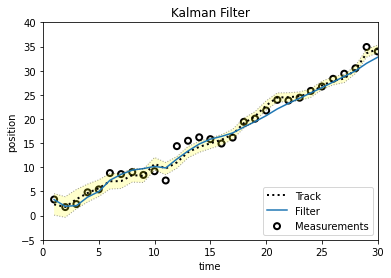

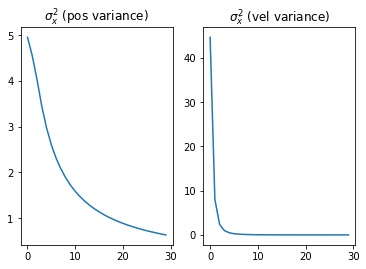

In [9]:
plot_track(xs[:, 0], gt[:], zs, covs,y_lim=(-5, 40))

## N dimensional Kalman Filter Class 구현하기

In [10]:
import numpy as np
# from numpy import dot, zeros, eye

class NdKalmanFilter():
    '''
    My N dimensional Kalman Filter
    '''
    def __init__(self, dim_x, dim_z, dim_u = 0):
        self.dim_x = dim_x
        self.dim_z = dim_z
        self.dim_u = dim_u
        print("you need to define the following \n self.x \n self.P \n self.B \n self.F \n self.Q \n self.R")
        self.x = np.zeros((dim_x,1))     # state mean
        self.P = np.eye(dim_x)           # state covariance
        self.B = 0                       # control transition matrix
        self.F = np.eye(dim_x)           # state transition matrix
        self.Q = np.eye(dim_x)           # process noise
        self.R = np.eye(dim_z)           # measurement noise 
        self.H = np.zeros((dim_z,dim_x)) # measurment function
        self.y = np.zeros((dim_z,1))     # residual (z-x)
        
        z = np.array([None]*self.dim_z)
        self.z = np.zeros((dim_z,1))
        """ ensure z is a (dim_z, 1) shaped vector"""
        
    def predict(self,u=0):
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.F,self.P),(self.F.T)) + self.Q
        
        return self.x, self.P
    
    def update(self,z):
        self.y = z - self.H @ x
        self.K = self.P @ self.H.T / (self.H @ self.P @ self.H.T + self.R)
        self.x = self.x + self.K*self.y
        #     print('post x is {}'.format(x))
        self.P = (np.eye(len(self.P))- self.K@self.H)@self.P@(np.eye(len(self.P))- self.K@self.H).T + self.R*self.K@self.K.T
        return self.x, self.P

In [11]:
nkf = NdKalmanFilter(dim_x=2, dim_z=1, dim_u=0)

you need to define the following 
 self.x 
 self.P 
 self.B 
 self.F 
 self.Q 
 self.R


In [12]:
dt=1
nkf.x = np.array([[0., 0.]]).T
print("initial state is \n{} \nand shape of {}".format(nkf.x, nkf.x.shape))
nkf.P = nkf.P*50 # np.array([[500, 0.],[0, 49]])
nkf.B = 0
nkf.F = np.array([[1., dt],[0.,1.]])
nkf.Q = np.array([[1., 2],[2, 4]])
nkf.R = np.array([[5.]])
nkf.H = np.array([[1., 0.]])


initial state is 
[[0.]
 [0.]] 
and shape of (2, 1)


In [14]:
xs, covs = [],[]

for z in zs:
    # predict 
    x, P = nkf.predict()
    # update
    x, P = nkf.update(z)
    xs.append(x)
    covs.append(P)
    
xs, covs = np.array(xs), np.array(covs) 

print(xs.shape)
print(covs.shape)


(30, 2, 1)
(30, 2, 2)


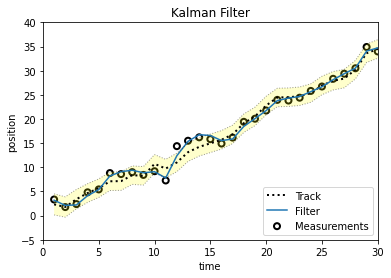

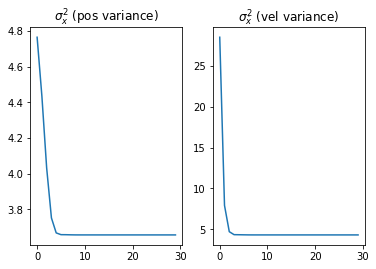

In [15]:
from kf_book.mkf_internal import plot_track
plot_track(xs[:, 0], gt[:], zs, covs,y_lim=(-5, 40))